# Polynomial Regression

Polynomial regression is a type of linear regression, known as a special case of multiple linear regression. It again makes predictions using only one independent variable, but assumes a nth degree polynomial relation between said independent variable and the dependent one.

Our assumption is also valid (just as is for linear regression) that the data that is to be predicted, is the sum of a deterministic function of the input and a random noise.

$$ r = f(x) + \epsilon $$

where r is the dependent variable, x is the independent variable and $\epsilon$ is the random noise.

Generalizing our estimator used in linear regression, we have

$$ g(x | W_k,...,W_1, W_0) = W_0 + W_1 \cdot x + ... + W_k \cdot x^k $$

which can also be written as

$$ g(x | W_k,...,W_1, W_0) = \sum_{i=0}^k W_i \cdot x^i $$

In [146]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10)

### Creating random polynomial data with noise

Generally, our function for the polynomial data can be written similarly to our estimator function.

$$ f(x) = \sum_{i=0}^k c_i \cdot x^i $$

where $c_i$ are the constants for every term in the function. 

Remember that we only write this here because we are generating the data that is going to be used in this tutorial. In a real world case, we would not know what type of function our data best fits, which is what we aim to find with our estimator function.

In [52]:
def func(x, c): 
    return sum([c[i] * x**i for i in range(len(c))])

num_data_points = 300
degree = 3

X = np.random.uniform(-10, 10, num_data_points)
c = [np.random.uniform(-3, 3) for _ in range(degree + 1)]
y = np.array( [func(X[i], c) for i in range(num_data_points)] )

mu, sigma = 0, 50
noise = np.random.normal(mu, sigma, num_data_points)

y = np.add(y, noise)

Let us plot the data.

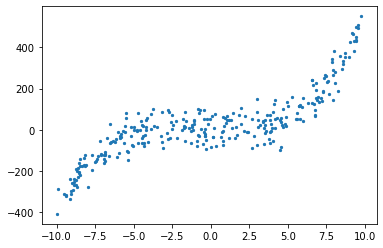

In [54]:
plt.scatter(X, y, s = 5)

We can methodize data creation part to use easily later.

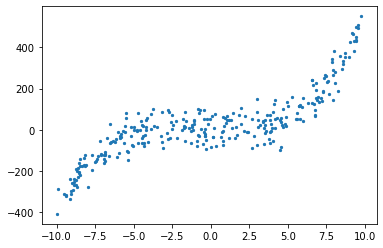

In [151]:
def create_poly_data(X=None, c=None, b=None, 
                     degree=3, num_points=300, 
                     X_lower=-10, X_higher=10, 
                     c_lower=-3, c_higher=3,
                     noise=True, noise_mu=0, 
                     noise_sigma=50, plot=False):
    
    def func(x, c): 
        return sum([c[i] * x**i for i in range(len(c))])
    
    if X == None: 
        X = np.random.uniform(X_lower, X_higher, num_points)
    if c == None: 
        c = [np.random.uniform(c_lower, c_higher) for _ in range(degree + 1)]
    
    y = np.array( [func(X[i], c) for i in range(num_points)] )
    
    if noise: 
        noise = np.random.normal(noise_mu, noise_sigma, num_points)
        y = [i + j for i, j in zip(y, noise)]
    
    if plot:
        plt.scatter(X, y, s = 5)
        plt.show()
        
    return X, c, y

np.random.seed(3)
X, c, y = create_poly_data(degree = 3, plot = True)

### Generating Training and Validation Sets

In [39]:
x_tr, y_tr = np.array(X[:len(X)*3//4]), np.array(y[:len(y)*3//4])
x_val, y_val = np.array(X[len(X)*3//4:]), np.array(y[len(y)*3//4:])

print('Training set length: {}\nValidation set length: {}'.format(len(x_tr), len(x_val)))

Training set length: 225
Validation set length: 75


### Random Initialization of Weights

In [41]:
degree = 3
W = [np.random.random() for _ in range(degree + 1)] #+1 is for W_0

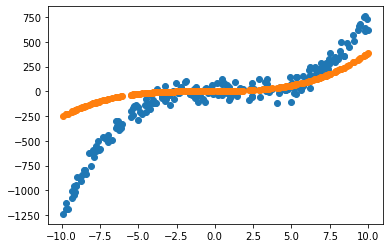

In [42]:
g = sum([W[i] * x_tr**i for i in range(len(W))])

plt.scatter(x_tr, y_tr)
plt.scatter(x_tr, g)

### Updating Weights

In order to update our weights, we are going to use the equation

$$ A \cdot W = y \Longrightarrow W = A^{-1} \cdot y $$ 

which is the same used for linear regression. Though now, we can generalize these matrices as follows.

$$ 
A = \begin{bmatrix} N & \sum x_i & ... & \sum x_i^k \\ 
    \sum x_i & \sum x_i^2 & ... & \sum x_i^{k+1} \\
    . & . & . & . \\
    . & . & . & . \\
    \sum x_i^k & ... & ... & \sum x_i^{2k}\end{bmatrix}, \quad
W = \begin{bmatrix} W_0 \\ W_1 \\ . \\ . \\ W_k \end{bmatrix}, \quad
y = \begin{bmatrix} \sum y_i \\ \sum y_i \cdot x_i \\ . \\ . \\ \sum y_i \cdot x_i^k \end{bmatrix}
$$

In [47]:
def update_weights(degree, x, y):
    A = np.linalg.inv(np.array( 
        [ [sum(np.power(x, i)) for i in range(j, degree + 1 + j)] for j in range(degree + 1) ]
    ))

    return np.dot(A, np.array( [ sum(y * np.power(x, i)) for i in range(degree+1) ] ))

def predict(W, x):
    return sum([W[i] * x**i for i in range(len(W))])
    
W = update_weights(3, x_tr, y_tr)
g = predict(W, x_tr)

Once again we create our plot to see if this time, our predictions does fit. Let us make two plots, one to see every training data predicted, and the other for validation data.

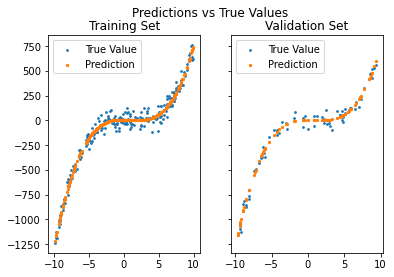

In [48]:
def plot_predictions(x_tr, y_tr, g, x_val, y_val, g_val):
    fig, axs = plt.subplots(1, 2, sharey = True)
    fig.suptitle('Predictions vs True Values')

    axs[0].scatter(x_tr, y_tr, s = 3, label = 'True Value')
    axs[0].scatter(x_tr, g, s = 5, label = 'Prediction')
    axs[0].legend()
    axs[0].set_title('Training Set')

    axs[1].scatter(x_val, y_val, s = 3, label = 'True Value')
    axs[1].scatter(x_val, g_val, s = 5, label = 'Prediction')
    axs[1].legend()
    axs[1].set_title('Validation Set')
    
    plt.show()
    
g_val = sum([W[i] * x_val**i for i in range(len(W))])

plot_predictions(x_tr, y_tr, g, x_val, y_val, g_val)

### Error

Now what about error again? Just as before, we use RSE.

In [171]:
def RSE(y, g): 
    return sum(np.square(y - g)) / sum(np.square(y - 1 / len(y)*sum(y)))

error = RSE(y_val, g_val)
print('RSE: {}'.format(error))

R_squared = 1 - error
print('R_squared: {:.4f}'.format(R_squared))

RSE: 0.08221345587660757
R_squared: 0.9178


### Predicting with lower degree polynomial predictors

Now let us take this a step further and see what if we assumed a 2nd degree relation between our data points and their corresponding values. We could calculate our new regressor with weights up to W squared term (remember that python range function is an open one on the upper end, meaning it does not include the upper end).

In [173]:
A = np.linalg.inv(np.array( 
    [ [sum(np.power(x_tr, i)) for i in range(j, degree + j)] for j in range(degree) ]
))

W = np.dot(A, np.array( [ sum(y_tr * np.power(x_tr, i)) for i in range(degree) ] ))

#Predictions
g = sum([W[i] * x_tr**i for i in range(len(W))])

Text(0.5, 1.0, 'Validation Set')

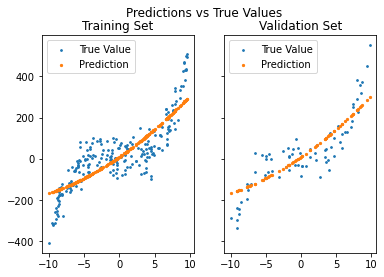

In [174]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.suptitle('Predictions vs True Values')

axs[0].scatter(x_tr, y_tr, s = 3, label = 'True Value')
axs[0].scatter(x_tr, g, s = 5, label = 'Prediction')
axs[0].legend()
axs[0].set_title('Training Set')

g_val = sum([W[i] * x_val**i for i in range(len(W))])
axs[1].scatter(x_val, y_val, s = 3, label = 'True Value')
axs[1].scatter(x_val, g_val, s = 5, label = 'Prediction')
axs[1].legend()
axs[1].set_title('Validation Set')

It is clear that we will have a larger error, since this fitting does a mediocre job predicting our generated values.

In [177]:
error = RSE(y_val, g_val)
print('RSE: {:.4f}'.format(error))

R_squared = 1 - error
print('R_squared: {:.4f}'.format(R_squared))

RSE: 0.2534
R_squared: 0.7466


In [181]:
degree = 6

A = np.linalg.inv(np.array( 
    [ [sum(np.power(x_tr, i)) for i in range(j, degree + j)] for j in range(degree) ]
))

W = np.dot(A, np.array( [ sum(y_tr * np.power(x_tr, i)) for i in range(degree) ] ))

#Predictions
g = sum([W[i] * x_tr**i for i in range(len(W))])

Text(0.5, 1.0, 'Validation Set')

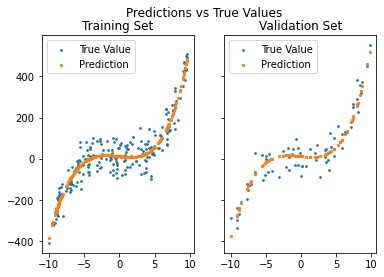

In [182]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.suptitle('Predictions vs True Values')

axs[0].scatter(x_tr, y_tr, s = 3, label = 'True Value')
axs[0].scatter(x_tr, g, s = 5, label = 'Prediction')
axs[0].legend()
axs[0].set_title('Training Set')

g_val = sum([W[i] * x_val**i for i in range(len(W))])
axs[1].scatter(x_val, y_val, s = 3, label = 'True Value')
axs[1].scatter(x_val, g_val, s = 5, label = 'Prediction')
axs[1].legend()
axs[1].set_title('Validation Set')

### Making a polynomial regression class

In [95]:
class regression():
    def __init__(self, degree):
        self.degree = degree
            
    def random_data(self, X=None, c=None, b=None, 
                         degree=3, num_points=300, 
                         X_lower=-10, X_higher=10, 
                         c_lower=-3, c_higher=3,
                         noise=True, noise_mu=0, 
                         noise_sigma=50, plot=False):

        def func(x, c): 
            return sum([c[i] * x**i for i in range(len(c))])

        if X == None: 
            self.X = np.random.uniform(X_lower, X_higher, num_points)
        if c == None: 
            self.c = [np.random.uniform(c_lower, c_higher) for _ in range(degree + 1)]

        self.y = np.array( [func(self.X[i], self.c) for i in range(num_points)] )

        if noise: 
            noise = np.random.normal(noise_mu, noise_sigma, num_points)
            self.y = [i + j for i, j in zip(self.y, noise)]

        if plot:
            plt.scatter(self.X, self.y, s = 5)
            plt.show()
        
        return self.X, self.y
            
    def split(self, X, y):
        x_tr, y_tr = np.array(X[:len(X)*3//4]), np.array(y[:len(y)*3//4])
        x_val, y_val = np.array(X[len(X)*3//4:]), np.array(y[len(y)*3//4:])
        
        return x_tr, y_tr, x_val, y_val

    def train(self, x, y):
        A = np.linalg.inv(np.array( 
            [ [sum(np.power(x, i)) for i in range(j, self.degree + 1 + j)] for j in range(self.degree + 1) ]
        ))

        self.W = np.dot(A, np.array( [ sum(y * np.power(x, i)) for i in range(self.degree+1) ] ))
    
    def predict(self, x):
        self.pred = sum([self.W[i] * x**i for i in range(len(self.W))])
        return self.pred
    
    def plot_data_vs_estimation(self, x, y, pred):
        plt.scatter(x, y, s = 3, label = 'True Value')
        plt.scatter(x, pred, s = 5, label = 'Prediction')
        plt.legend()
        plt.show()
        
    def RSE(self, y, g): 
        return sum(np.square(y - g)) / sum(np.square(y - 1 / len(y)*sum(y)))

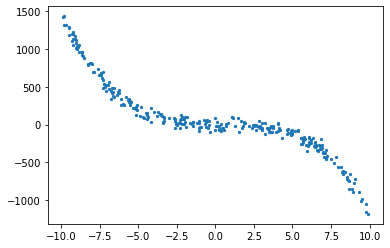

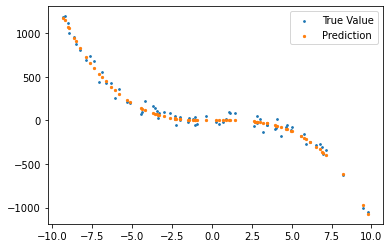

Error: 0.01


In [96]:
r = regression(3)
X, y = r.random_data(degree = 3, plot = True)
x_tr, y_tr, x_val, y_val = r.split(X, y)
r.train(x_tr, y_tr)
preds = r.predict(x_val)
r.plot_data_vs_estimation(x_val, y_val, preds)
print('Error: {:.2f}'.format(r.RSE(y_val, preds)))

## Using Numpy for Regression

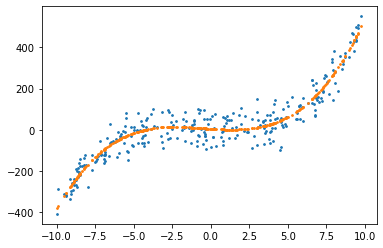

In [152]:
np_model = np.poly1d(np.polyfit(X, y, 3))

plt.scatter(X, y, s = 3, label = 'Data')
plt.scatter(X, np_model(X), s = 3, label = 'Numpy Predictions')

## Using Scikit-Learn for Regression

In [131]:
num_data_points, degree = 300, 3

def func(x, c): 
    return sum([c[i] * x**i for i in range(len(c))])

X = np.random.uniform(-10, 10, num_data_points)
c = [np.random.uniform(-3, 3) for _ in range(degree + 1)]
X1 = np.array([c[3] * X**3,
    c[2] * X**2,
    c[1] * X,
    [c[0]] * len(X)])
y = np.array( [func(X[i], c) for i in range(num_data_points)] )

from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 3)
poly_features = poly.fit_transform(X1.reshape(-1, 1))
print(poly_features)
model = LR()
model.fit(poly_features, y)

preds = model.predict(X1.reshape(-1, 1))

#Score model
print('Training score: ', model.score(X1.reshape(-1, 1), y))

#Plot
plt.scatter(X, y, s = 3, label = 'Data')
plt.scatter(X, preds, s = 3, label = 'Model Predictions')
plt.scatter(X, np.polyfit(X, y, 3), s = 3, 'Numpy Predictions')
plt.legend()

[[ 1.00000000e+00 -1.81977092e+03  3.31156620e+06 -6.02629188e+09]
 [ 1.00000000e+00 -1.83000622e+01  3.34892275e+02 -6.12854944e+03]
 [ 1.00000000e+00  1.17266054e+03  1.37513274e+06  1.61256390e+09]
 ...
 [ 1.00000000e+00 -1.58019013e+00  2.49700086e+00 -3.94573613e+00]
 [ 1.00000000e+00 -1.58019013e+00  2.49700086e+00 -3.94573613e+00]
 [ 1.00000000e+00 -1.58019013e+00  2.49700086e+00 -3.94573613e+00]]


ValueError: Found input variables with inconsistent numbers of samples: [1200, 300]